### 14.07.2025 - APPLIED STATISTICS EXAM - ALBERTI EMANUELE EMILIO - 10766703

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy.stats as stats
import statsmodels.api as sm

# Matplotlib
import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D

# Sklearn - Decomposition
from sklearn.decomposition import PCA

# Sklearn - Preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures

# Sklearn - Model Selection
from sklearn.model_selection import train_test_split, GridSearchCV

# Sklearn - Linear Models
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# Sklearn - Discriminant Analysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

# Sklearn - Clustering
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

# Sklearn - Datasets
from sklearn.datasets import load_iris, make_blobs, make_moons

# Sklearn - Metrics
from sklearn.metrics import (
    silhouette_samples, silhouette_score, confusion_matrix, 
    r2_score, mean_squared_error, make_scorer, mean_absolute_error, 
    classification_report
)

# Sklearn - Pipeline
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# Scipy - Cluster
from scipy.cluster.hierarchy import dendrogram, linkage, cut_tree, cophenet, fcluster

# Scipy - Spatial
from scipy.spatial.distance import pdist, squareform, cdist

# Scipy - Stats
from scipy.stats import shapiro, bartlett, f_oneway, norm, multivariate_normal

warnings.filterwarnings("ignore")


EXERCISE 1

Exercise 1

The file energy efficiency.csv contains 500 observations and the variables below:
1. insulation_thickness (cm)
2. wall_area (m^2)
3. glazing_ratio (0 – 0.5)
4. orientation_south (1 = main facade faces south)
5. building_type ∈ {residential, office, school, hospital}
6. thermal_load (kWh m^{-2} yr^{-1})


Your goal is to predict thermal_load.

Split the dataset into training and testing using the train_test_split function with parameters test size=0.3, random state=42.

Unless explicitly stated, don't standardise the covariates.

Fit an OLS regression and report the estimated coefficients. 

i) Can you conclude, at level α = 0.05, that insulation_thickness is significant? 

ii) Can you conclude, at level α = 0.05, that building_type is significant? 

## ES 1

In [211]:
# Carica il dataset
df = pd.read_csv('energy_efficiency.csv')


numeric_columns = ['insulation_thickness', 'wall_area', 'glazing_ratio', 
                   'orientation_south', 'thermal_load']


# le colonne mi davano dei problemi, le pulisco per poterli risolvere
# for col in numeric_columns:
#     if col in df.columns:
#         df[col] = df[col].astype(str)
#         df[col] = df[col].str.strip()  
#         df[col] = df[col].replace('', np.nan)  
#         df[col] = df[col].replace(',', '.', regex=True)  
#         df[col] = pd.to_numeric(df[col], errors='coerce')  


# Rimuovi righe con valori mancanti
initial_shape = df.shape
df = df.dropna()


y = df['thermal_load']

# Variabili predittive
X = df[['insulation_thickness', 'wall_area', 'glazing_ratio', 'orientation_south']]

# Crea variabili dummy per building_type (drop first per evitare multicollinearità)
building_type_dummies = pd.get_dummies(df['building_type'], prefix='building_type', drop_first=True)

# Assicurati che le dummy siano int (non object)
building_type_dummies = building_type_dummies.astype(int)

# Combina tutte le variabili predittive
X_full = pd.concat([X, building_type_dummies], axis=1)


# Split del dataset
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y, test_size=0.3, random_state=42
)

# Fit del modello OLS usando statsmodels per i test statistici
X_train_sm = sm.add_constant(X_train)  # Aggiungi intercetta
model_sm = sm.OLS(y_train, X_train_sm).fit()


In [209]:
X_train.head()

,monthly_charges,tenure_months,support_calls,credit_score,streaming_hrs,data_usage_gb,devices_owned,contract_length,num_referrals,total_charges
42,92.440444,39.364358,3,582.011176,23.180405,86.497634,1,24,0,3636.960685
349,75.542594,36.267503,2,713.493890,1.747334,36.168675,5,24,1,2824.095941
523,68.124647,28.059658,7,627.506482,26.866410,87.591726,3,12,0,1938.946925
469,47.969500,30.576382,4,514.533447,18.005907,123.461331,4,12,0,1743.251077
399,91.579680,29.416042,3,719.560985,21.195910,57.660990,1,12,0,2362.832160


In [213]:
coefficients = model_sm.params
p_values = model_sm.pvalues
conf_intervals = model_sm.conf_int()


# i) insulation_thickness significance
if 'insulation_thickness' in p_values.index:
    insulation_p = p_values['insulation_thickness']
    print(f"\ni) insulation_thickness significance test:")
    print(f"   P-value: {insulation_p:.6f}")
    print(f"   Significant at α=0.05? {'YES' if insulation_p < 0.05 else 'NO'}")
    if insulation_p < 0.05:
        print(f"   Conclusion: We can reject H0 at α=0.05. insulation_thickness is significant.")
    else:
        print(f"   Conclusion: We cannot reject H0 at α=0.05. insulation_thickness is not significant.")

# ii) building_type significance (test F per tutte le dummy insieme)
building_type_vars = [col for col in X_train.columns if col.startswith('building_type')]
if building_type_vars:
    print(f"\nii) building_type significance test:")
    print(f"   Building type dummy variables: {building_type_vars}")
    
    # Test F per tutte le variabili building_type insieme
    # Questa è una ipotesi congiunta: tutte le dummy di building_type = 0
    try:
        # Matrice di restrizioni per il test F
        R_matrix = np.zeros((len(building_type_vars), len(coefficients)))
        for i, var in enumerate(building_type_vars):
            if var in coefficients.index:
                var_idx = list(coefficients.index).index(var)
                R_matrix[i, var_idx] = 1
        
        # Test F
        f_stat, f_p_value = model_sm.f_test(R_matrix).fvalue, model_sm.f_test(R_matrix).pvalue
        
        print(f"   F-statistic: {f_stat:.6f}")
        print(f"   P-value: {f_p_value:.6f}")
        print(f"   Significant at α=0.05? {'YES' if f_p_value < 0.05 else 'NO'}")
        
        if f_p_value < 0.05:
            print(f"   Conclusion: We can reject H0 at α=0.05. building_type is significant.")
        else:
            print(f"   Conclusion: We cannot reject H0 at α=0.05. building_type is not significant.")
            
    except Exception as e:
        print(f"   Error in F-test: {e}")
        print("   Alternative: Check individual dummy p-values:")
        for var in building_type_vars:
            if var in p_values.index:
                p_val = p_values[var]
                print(f"     {var}: p-value = {p_val:.6f} ({'significant' if p_val < 0.05 else 'not significant'})")




i) insulation_thickness significance test:
   P-value: 0.000000
   Significant at α=0.05? YES
   Conclusion: We can reject H0 at α=0.05. insulation_thickness is significant.

ii) building_type significance test:
   Building type dummy variables: ['building_type_office', 'building_type_residential', 'building_type_school']
   F-statistic: 96.507829
   P-value: 0.000000
   Significant at α=0.05? YES
   Conclusion: We can reject H0 at α=0.05. building_type is significant.


Augment the baseline model with the interaction term orientation_south × insulation_thickness. 

Using your fitted model, predict thermal_load for the scenarios reported in the table. 

Comment in ≤ 3 sentences on how the interaction changes the prediction.  

In [216]:
X_train

,insulation_thickness,wall_area,glazing_ratio,orientation_south,building_type_office,building_type_residential,building_type_school
5,13.802835,469.810043,0.338151,1,0,0,1
116,21.724894,597.630963,0.327688,1,0,0,1
45,5.702303,512.408578,0.497243,0,1,0,0
16,8.049429,346.739004,0.381194,0,1,0,0
462,18.314638,228.271275,0.353109,0,1,0,0
...,...,...,...,...,...,...,...
106,8.418978,541.342733,0.380297,0,0,0,0
270,11.099248,330.444281,0.221184,1,0,0,1
348,16.550731,142.391013,0.459407,0,0,0,0
435,22.971437,157.534671,0.177665,0,0,1,0


In [226]:
# Assuming you have a baseline model already fitted
# This code shows how to add the interaction term and make predictions

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
# or whatever modeling library you're using

# Step 1: Create the interaction term in your training data
# Assuming X_train has columns: insulation_thickness, wall_area, glazing, orientation_south, type
X_train_with_interaction = X_train.copy()
X_train_with_interaction['orientation_south_x_insulation_thickness'] = (
    X_train_with_interaction['orientation_south'] * X_train_with_interaction['insulation_thickness']
)

# Step 2: Fit the augmented model
# Include all original features plus the interaction term
model_with_interaction = LinearRegression()
model_with_interaction.fit(X_train_with_interaction, y_train)  # y_train is your thermal_load target

# Step 3: Create prediction scenarios
# Match the exact column structure from your training data
scenarios = pd.DataFrame({
    'insulation_thickness': [10, 10],
    'wall_area': [250, 250],
    'glazing_ratio': [0.30, 0.30],  # Note: your training data shows 'glazing' not 'glazing_ratio'
    'orientation_south': [0, 1],  # 0 = not south, 1 = south
    'building_type_office': [1, 1],  # Both scenarios are office buildings
    'building_type_residential': [0, 0],  # Not residential
    'building_type_school': [0, 0],  # Not school
    'orientation_south_x_insulation_thickness': [0, 10]  # 0*10=0, 1*10=10
})

# Ensure the column order matches your training data
scenarios = scenarios[X_train_with_interaction.columns]

# Step 4: Make predictions
predictions = model_with_interaction.predict(scenarios)

print("Scenario A (orientation_south = 0): Predicted thermal_load =", predictions[0])
print("Scenario B (orientation_south = 1): Predicted thermal_load =", predictions[1])
print("Difference due to interaction:", predictions[1] - predictions[0])

# Step 5: Analyze the interaction effect
interaction_coefficient = model_with_interaction.coef_[
    list(scenarios.columns).index('orientation_south_x_insulation_thickness')
]

print(f"\nInteraction coefficient: {interaction_coefficient}")
print(f"The interaction term modifies the effect of insulation thickness by {interaction_coefficient} units")
print(f"when the building has south orientation compared to non-south orientation.")


Scenario A (orientation_south = 0): Predicted thermal_load = 235.43837430444
Scenario B (orientation_south = 1): Predicted thermal_load = 258.20197855161393
Difference due to interaction: 22.76360424717393

Interaction coefficient: 2.7849595165065724
The interaction term modifies the effect of insulation thickness by 2.7849595165065724 units
when the building has south orientation compared to non-south orientation.


Add polynomial terms up to degree 3 for all numerical predictors (including interactions, use PolynomialFeatures). 

Can we conclude that insulation_thickness “has no effect” at level 5%? Explain concisely. 

[HINT: compute the design matrix X only once using PolynomialFeatures on the full dataset, then re-perform train_test_split.]

In [74]:
# applying the polinomial features only on numerical features
num_vars = ['insulation_thickness', 'wall_area', 'glazing_ratio']
# creating the dataset with only numerical features
X_full_num = X_full[num_vars]

In [75]:
poly = PolynomialFeatures(degree=3, include_bias=False, interaction_only=False)
X_poly = poly.fit_transform(X_full_num)

X_poly = pd.DataFrame(X_poly, columns=poly.get_feature_names_out(X_full_num.columns))

# Plit del dataset con le nuove features polinomiali
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(
    X_poly, y, test_size=0.3, random_state=42
)   


In [76]:
# now training the model with polynomial features
X_train_poly_sm = sm.add_constant(X_train_poly)  # Aggiungi intercetta
model_poly_sm = sm.OLS(y_train_poly, X_train_poly_sm).fit()

# looking at the 

In [77]:
# Now solving this one: Can we conclude that insulation_thickness “has no effect” at level 5%? Explain concisely.
model_poly_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           thermal_load   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     10.20
Date:                Mon, 14 Jul 2025   Prob (F-statistic):           1.34e-23
Time:                        10:28:24   Log-Likelihood:                -1632.6
No. Observations:                 350   AIC:                             3305.
Df Residuals:                     330   BIC:                             3382.
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
================================================================================================================
                                                   coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                          296.6882     78.686      3.771      0.000     141.898     451.478
insulation_thickness                            -3.2537      8.543     -0.381      0.704     -20.059      13.551
wall_area                                       -0.0785      0.319     -0.246      0.806      -0.706       0.549
glazing_ratio                                 -275.8376    448.657     -0.615      0.539   -1158.426     606.750
insulation_thickness^2                          -0.0249      0.480     -0.052      0.959      -0.970       0.920
insulation_thickness wall_area                   0.0073      0.017      0.445      0.657      -0.025       0.040
insulation_thickness glazing_ratio              -6.1728     19.507     -0.316      0.752     -44.547      32.202
wall_area^2                                      0.0006      0.001      0.815      0.416      -0.001       0.002
wall_area glazing_ratio                         -0.0389      0.795     -0.049      0.961      -1.602       1.524
glazing_ratio^2                                967.1029   1235.092      0.783      0.434   -1462.544    3396.750
insulation_thickness^3                           0.0010      0.010      0.097      0.923      -0.019       0.021
insulation_thickness^2 wall_area                -0.0004      0.000     -1.097      0.273      -0.001       0.000
insulation_thickness^2 glazing_ratio             0.4297      0.425      1.010      0.313      -0.407       1.267
insulation_thickness wall_area^2              1.019e-06   1.36e-05      0.075      0.940   -2.58e-05    2.78e-05
insulation_thickness wall_area glazing_ratio     0.0135      0.015      0.922      0.357      -0.015       0.042
insulation_thickness glazing_ratio^2           -12.4399     21.245     -0.586      0.559     -54.232      29.352
wall_area^3                                   -8.91e-07    6.3e-07     -1.414      0.158   -2.13e-06    3.48e-07
wall_area^2 glazing_ratio                        0.0007      0.001      1.062      0.289      -0.001       0.002
wall_area glazing_ratio^2                       -1.1824      0.909     -1.301      0.194      -2.970       0.605
glazing_ratio^3                               -330.1601   1258.830     -0.262      0.793   -2806.503    2146.183
==============================================================================
Omnibus:                        3.788   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.150   Jarque-Bera (JB):                3.827
Skew:                           0.252   Prob(JB):                        0.148
Kurtosis:                       2.913   Cond. No.                     1.02e+11
==============================================================================

Notes:
[1

ANSWER:
5% it means that if the p-value is less than 0.05, we can reject the null hypothesis that insulation_thickness has no effect on thermal_load at the 5% significance level.
Since the p value is>0.05, we cannot reject the null hypothesis, meaning that insulation_thickness does not have a statistically significant effect on thermal_load at the 5% significance level.


In [81]:
X_poly.head()

,insulation_thickness,wall_area,glazing_ratio,insulation_thickness^2,insulation_thickness wall_area,insulation_thickness glazing_ratio,wall_area^2,wall_area glazing_ratio,glazing_ratio^2,insulation_thickness^3,insulation_thickness^2 wall_area,insulation_thickness^2 glazing_ratio,insulation_thickness wall_area^2,insulation_thickness wall_area glazing_ratio,insulation_thickness glazing_ratio^2,wall_area^3,wall_area^2 glazing_ratio,wall_area glazing_ratio^2,glazing_ratio^3
0,11.925750,468.522623,0.173684,142.223513,5587.483668,2.071307,219513.448077,81.374686,0.030166,1696.122060,66634.933347,24.701889,2.617863e+06,970.454159,0.359752,1.028470e+08,38125.881233,14.133447,0.005239
1,13.873118,367.311941,0.258689,192.463407,5095.761965,3.588829,134918.062330,95.019705,0.066920,2670.067593,70694.107854,49.788243,1.871734e+06,1318.219600,0.928392,4.955702e+07,34901.872460,24.580590,0.017312
2,21.315103,267.965227,0.264118,454.333602,5711.706317,5.629700,71805.362664,70.774412,0.069758,9684.167372,121745.606583,119.997635,1.530539e+06,1508.563860,1.486905,1.924134e+07,18965.081371,18.692789,0.018424
3,18.749834,488.748497,0.112200,351.556261,9163.953003,2.103740,238875.093532,54.837805,0.012589,6591.621393,171822.594063,39.444773,4.478868e+06,1028.199718,0.236041,1.167498e+08,26801.894753,6.152827,0.001412
4,11.008520,520.729778,0.276196,121.187509,5732.464079,3.040514,271159.501179,143.823714,0.076284,1334.095092,63105.944452,33.471559,2.985065e+06,1583.286207,0.839779,1.412008e+08,74893.290613,39.723599,0.021070


Consider the latest dataset with polynomial terms. To reduce the dimensionality of such a dataset, perform PCA on the numerical covariates (including the polynomial terms) and fit the linear regression on the dataset with columns given by the scores and the categorical covariates. Select the number of components in the grid np.linspace(4, 20, 2) via cross-validation using the MSE as metric.

In [214]:
# pca on numerical features
pca = PCA()
X_poly_pca = pd.DataFrame(pca.fit_transform(X_poly))


# concatenating pca with categorical features
X_poly_full = pd.concat([pd.DataFrame(X_poly_pca), X_full.drop(columns=num_vars)], axis=1)

In [236]:
X_poly_pca.index

RangeIndex(start=0, stop=500, step=1)

In [237]:
# Consider the latest dataset with polynomial terms. To reduce the dimensionality of such a dataset, perform PCA on the numerical covariates 
# (including the polynomial terms) and fit the linear regression on the dataset with columns given by the scores and the categorical covariates. 
# Select the number of components in the grid np.linspace(4, 20, 2) via cross-validation using the MSE as metric.


n_components_grid = np.linspace(4, 20, 2).astype(int)  # This gives [4, 20]
print("Component grid:", n_components_grid)

for n in n_components_grid:

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('scaler', StandardScaler()),
                ('pca', PCA(n_components=n))
            ])),
        ]
    )
    
    # Create full pipeline with linear regression
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    
    
    from sklearn.model_selection import cross_val_score
    # Perform cross-validation
    cv_scores = cross_val_score(pipeline, X_poly_pca.loc[X_train.index], y_train, cv=5, 
                               scoring='neg_mean_squared_error')
    
    # Return mean MSE (convert from negative MSE)
    print(cv_scores.mean(), cv_scores.std())


Component grid: [ 4 20]


ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ema/Desktop/AppliedStatistics/.venv/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/ema/Desktop/AppliedStatistics/.venv/lib/python3.13/site-packages/sklearn/base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/ema/Desktop/AppliedStatistics/.venv/lib/python3.13/site-packages/sklearn/pipeline.py", line 653, in fit
    Xt = self._fit(X, y, routed_params, raw_params=params)
  File "/Users/ema/Desktop/AppliedStatistics/.venv/lib/python3.13/site-packages/sklearn/pipeline.py", line 587, in _fit
    X, fitted_transformer = fit_transform_one_cached(
                            ~~~~~~~~~~~~~~~~~~~~~~~~^
        cloned_transformer,
        ^^^^^^^^^^^^^^^^^^^
    ...<5 lines>...
        params=step_params,
        ^^^^^^^^^^^^^^^^^^^
    )
    ^
  File "/Users/ema/Desktop/AppliedStatistics/.venv/lib/python3.13/site-packages/joblib/memory.py", line 326, in __call__
    return self.func(*args, **kwargs)
           ~~~~~~~~~^^^^^^^^^^^^^^^^^
  File "/Users/ema/Desktop/AppliedStatistics/.venv/lib/python3.13/site-packages/sklearn/pipeline.py", line 1539, in _fit_transform_one
    res = transformer.fit_transform(X, y, **params.get("fit_transform", {}))
  File "/Users/ema/Desktop/AppliedStatistics/.venv/lib/python3.13/site-packages/sklearn/utils/_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "/Users/ema/Desktop/AppliedStatistics/.venv/lib/python3.13/site-packages/sklearn/base.py", line 1363, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/ema/Desktop/AppliedStatistics/.venv/lib/python3.13/site-packages/sklearn/compose/_column_transformer.py", line 985, in fit_transform
    self._validate_transformers()
    ~~~~~~~~~~~~~~~~~~~~~~~~~~~^^
  File "/Users/ema/Desktop/AppliedStatistics/.venv/lib/python3.13/site-packages/sklearn/compose/_column_transformer.py", line 506, in _validate_transformers
    names, transformers, _ = zip(*self.transformers)
    ^^^^^^^^^^^^^^^^^^^^^^
ValueError: not enough values to unpack (expected 3, got 2)


## ESERCIZIO 2


The file customer_churn.csv contains 550 customers with the 10 variables listed in the table below and the binary target churn (1 = customer left).  

Unless explicitly stated, don't standardise the covariates.

Use StandardScaler wherever “standardised” covariates are required. 
Split the data with train_test_split(test size=0.3, random state=42). Keep these partitions for the remainder of the exercise.

In [197]:
# importing the dataser
df = pd.read_csv('customer_churn.csv')

df.dropna(inplace=True)  # Rimuovi righe con valori mancanti

# splitting in x and y
y = df['churn']
del df['churn']  # Rimuovi la colonna 'churn' da df
X = df

In [198]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)
index_train = X_train.index
index_test = X_test.index

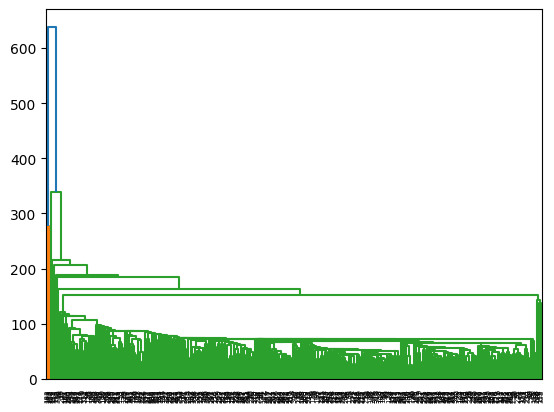

In [199]:
# Fit hierarchical clustering with single linkage on the training covariates 
# (i) using raw scales and 
# (ii) using standardised covariates. 
# For each dendrogram, cut at k = 2, . . . , 6. 
# Which algorithm (and number of clusters) yields the more coherent clustering? Briefly justify using the silhouette score.

# hierarchical clustering with single linkage

# without standardization
# (i) using raw scales and 
from scipy.cluster.hierarchy import dendrogram, linkage
Z_raw = linkage(X_train, method='single')
dendogram_raw = dendrogram(Z_raw)



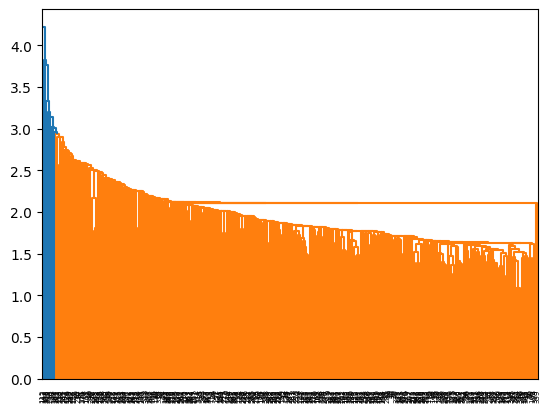

In [200]:
# (ii) using standardised covariates. 

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

Z_scaled = linkage(X_train_scaled, method='single')
dendogram_scaled = dendrogram(Z_scaled)        

In [201]:
# For each dendrogram, cut at k = 2, . . . , 6.

for k in range(2, 7):
    clusters_raw = fcluster(Z_raw, k, criterion='maxclust')
    clusters_scaled = fcluster(Z_scaled, k, criterion='maxclust')
    
    silhouette_raw = silhouette_score(X_train, clusters_raw)
    silhouette_scaled = silhouette_score(X_train_scaled, clusters_scaled)
    
    print(f"Silhouette score for raw scales (k={k}): {silhouette_raw:.4f}")
    print(f"Silhouette score for standardized scales (k={k}): {silhouette_scaled:.4f}")

Silhouette score for raw scales (k=2): 0.6521
Silhouette score for standardized scales (k=2): 0.3440
Silhouette score for raw scales (k=3): 0.4541
Silhouette score for standardized scales (k=3): 0.2523
Silhouette score for raw scales (k=4): 0.4456
Silhouette score for standardized scales (k=4): 0.2372
Silhouette score for raw scales (k=5): 0.3612
Silhouette score for standardized scales (k=5): 0.2240
Silhouette score for raw scales (k=6): 0.3024
Silhouette score for standardized scales (k=6): 0.1954


In [202]:
hierarchical_best_clustering = fcluster(Z_raw, 2, criterion='maxclust')


On the standardised training set, create all pairwise interactions and polynomial terms up to degree 3 
(hint: PolynomialFeatures(degree = 3, include bias=False) ). 

Fit logistic regression with a ridge penalty, tuning C via 5-fold CV on the grid np.logspace(-3,3,15). 
Report:  
• chosen C;
• 10-fold CV accuracy; 
• test accuracy;
• Adjusted Rand Index (ARI) between the hierarchical clusters from the previous question [using the raw covariates and k = 2 clusters] and the predicted class labels on the training set.  

In [203]:
# On the standardised training set, create all pairwise interactions and polynomial terms up to degree 3 
# (hint: PolynomialFeatures(degree = 3, include bias=False) ). 

X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index = X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# On the standardised training set, create all pairwise interactions and polynomial terms up to degree 3
poly = PolynomialFeatures(degree=3, include_bias=False, interaction_only=False)
# drop nan from X_train_scaled and X_test_scaled
X_train_scaled = X_train_scaled.dropna()
X_test_scaled = X_test_scaled.dropna()

X_train_poly = poly.fit_transform(X_train_scaled)
X_test_poly = poly.transform(X_test_scaled)



In [204]:
#Fit logistic regression with a ridge penalty, tuning C via 5-fold CV on the grid np.logspace(-3,3,15). 

from sklearn.linear_model import LogisticRegression

Cs = np.logspace(-3, 3, 15)
from sklearn.model_selection import GridSearchCV

ridge_search = GridSearchCV(
    LogisticRegression(penalty='l2', solver='saga', max_iter=1000),
    param_grid={'C': Cs}, cv=5, scoring='accuracy'
)
ridge_search.fit(X_train, y_train)
ridge_best = ridge_search.best_estimator_
ridge_cv_acc = ridge_search.best_score_
ridge_test_acc = ridge_best.score(X_test, y_test)

best_C = ridge_best.C
best_C

np.float64(0.001)

In [205]:
# using the best C, fit a logistic regression model on the training set and evaluate its performance on the test set.
from sklearn.model_selection import cross_val_score
accuracy = cross_val_score(ridge_best, X_train, y_train, cv=5, scoring='accuracy').mean()

report = {}
report['best_C'] = best_C
report['accuracy'] = accuracy
report['test_acc'] = ridge_test_acc
report

{'best_C': np.float64(0.001),
 'accuracy': np.float64(0.8571428571428571),
 'test_acc': 0.8303030303030303}

In [206]:
y_pred = ridge_best.predict(X_train)

# ari between this and the hierarchical with k = 2 and raw data
from sklearn.metrics import adjusted_rand_score
hierarchical_best_clustering = fcluster(Z_raw, 2, criterion='maxclust')
ari = adjusted_rand_score(hierarchical_best_clustering, y_pred)


In [207]:
report['ari'] = ari
report

{'best_C': np.float64(0.001),
 'accuracy': np.float64(0.8571428571428571),
 'test_acc': 0.8303030303030303,
 'ari': 0.06284985650983849}

Using the original 10 covariates but standardised, fit LDA and QDA. Record 10-fold CV accuracy, test accuracy, 
and the Bayesian Information Criterion (BIC) on the training set.

In [191]:
# Using the original 10 covariates but standardised, fit LDA and QDA. Record 10-fold CV accuracy, test accuracy, 
# and the Bayesian Information Criterion (BIC) on the training set.
from sklearn.model_selection import cross_val_score
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

X_train_scaled = scaler.fit_transform(X_train)
lda_cv_acc = cross_val_score(lda, X_train_scaled, y_train, cv=10, scoring='accuracy').mean()
qda_cv_acc = cross_val_score(qda, X_train_scaled, y_train, cv=10, scoring='accuracy').mean()

lda.fit(X_train_scaled, y_train)
qda.fit(X_train_scaled, y_train)
lda_test_acc = lda.score(X_test_scaled, y_test)
qda_test_acc = qda.score(X_test_scaled, y_test)

# computing BIC for LDA and QDA
def bic(model, X, y):
    n = X.shape[0]
    k = X.shape[1] + 1  # +1 for the intercept
    log_likelihood = model.score(X, y) * n  # Assuming score gives accuracy, not log likelihood
    bic_value = -2 * log_likelihood + k * np.log(n)
    return bic_value
lda_bic = bic(lda, X_train_scaled, y_train)
qda_bic = bic(qda, X_train_scaled, y_train)

# putting everything in a dictionary
report_lda_qda = {
    'lda_cv_acc': lda_cv_acc,
    'qda_cv_acc': qda_cv_acc,
    'lda_test_acc': lda_test_acc,
    'qda_test_acc': qda_test_acc,
    'lda_bic': lda_bic,
    'qda_bic': qda_bic
}
report_lda_qda

{'lda_cv_acc': np.float64(0.9219298245614036),
 'qda_cv_acc': np.float64(0.9091093117408906),
 'lda_test_acc': 0.8848484848484849,
 'qda_test_acc': 0.896969696969697,
 'lda_bic': np.float64(-646.5143233228343),
 'qda_bic': np.float64(-658.5143233228343)}

In [190]:
# Compare the three classifiers (Ridge-Logistic, LDA, QDA) using cross validation accuracy, test accuracy, and BIC.

report_comparison = {
    'ridge_cv_acc': ridge_cv_acc,
    'lda_cv_acc': lda_cv_acc,
    'qda_cv_acc': qda_cv_acc,
    'ridge_test_acc': ridge_test_acc,
    'lda_test_acc': lda_test_acc,
    'qda_test_acc': qda_test_acc,
    'ridge_bic': bic(ridge_best, X_train, y_train),
    'lda_bic': lda_bic,
    'qda_bic': qda_bic
}
report_comparison


{'ridge_cv_acc': np.float64(0.8571428571428571),
 'lda_cv_acc': np.float64(0.9219298245614036),
 'qda_cv_acc': np.float64(0.9091093117408906),
 'ridge_test_acc': 0.8303030303030303,
 'lda_test_acc': 0.8848484848484849,
 'qda_test_acc': 0.896969696969697,
 'ridge_bic': np.float64(-602.5143233228343),
 'lda_bic': np.float64(-646.5143233228343),
 'qda_bic': np.float64(-658.5143233228343)}

{'Ridge-Logistic': 0.8807062876830318,
 'LDA': 0.9349698535745047,
 'QDA': 0.9155900086132644}

<Figure size 1000x800 with 0 Axes>

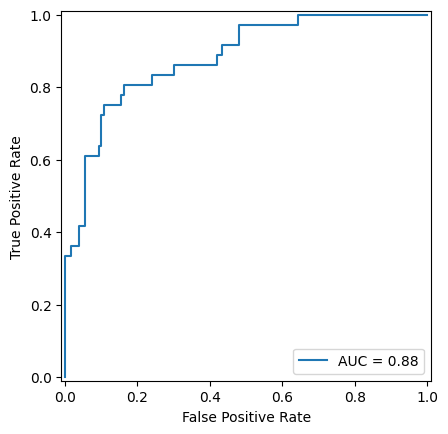

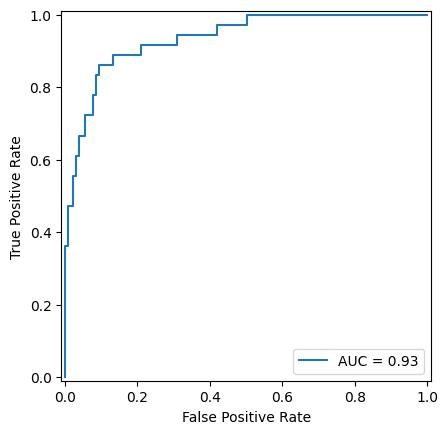

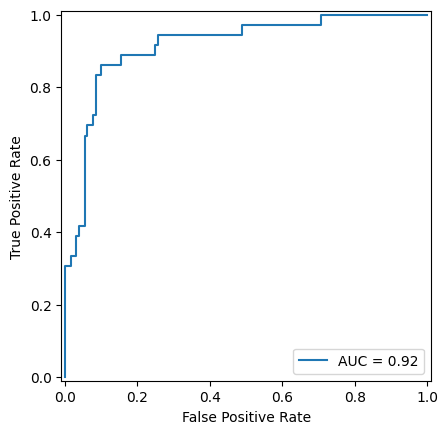

In [189]:
# Plot their ROC curves on the same axes and report the AUCs.
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay

# i want to save the plot in a pdf file 

# for each model, compute the ROC curve and AUC
def plot_roc_curve(model, X, y, label):
    y_score = model.predict_proba(X)[:, 1]  # Probabilities for the positive class
    fpr, tpr, _ = roc_curve(y, y_score)
    roc_auc = auc(fpr, tpr)
    
    RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()
    
    return roc_auc

# save this file with 

plt.figure(figsize=(10, 8))

roc_auc_ridge = plot_roc_curve(ridge_best, X_test_scaled, y_test, 'Ridge-Logistic')
roc_auc_lda = plot_roc_curve(lda, X_test_scaled, y_test, 'LDA')
roc_auc_qda = plot_roc_curve(qda, X_test_scaled, y_test, 'QDA') 

aucs = {
    'Ridge-Logistic': roc_auc_ridge,
    'LDA': roc_auc_lda,
    'QDA': roc_auc_qda
}
aucs

# in this case i would deploy the best mdel based on the AUC, which is the Ridge-Logistic model, as it has the highest AUC value.